# Assignment 8

In this assignment we'll estimate a regression model using the horseshoe prior. We're going to analyze [some data I found on Kaggle](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction) and try to predict the price of flights. 

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. Your work will be manually graded by our TA. 


### Data Cleaning

I will make some transformations to prepare this data set for regression:

 - create dummy columns for the categorical data,
 - transform price to log price,
 - create interaction terms.

Note that my decision to disregard certain columns, or interactions or transformations is a reflection of my prior knowledge. Ommitting a column is equivalent to setting a very informative prior for that hypothetical column's weight (centered at $0$). Commonly performed procedures have a place in the Bayesian philosophy, and are not as ad hoc as they seem to be in the frequentist domain!

In [1]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

C:\Users\pfost\anaconda3\envs\ds_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
os.chdir("C:\Virginia\Semester3\Bayes\HW8")

In [6]:
flights = pd.read_csv("Clean_Dataset.csv", index_col=0)
flights.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [7]:
# change dependent variable by taking the logarithm
flights['log_price'] = np.log(flights['price'])
flights = flights.drop('price', axis=1)

In [8]:
# create airlines dummies
# baseline is "other" (AirAsia","GO_FIRST", or "SpiceJet")
airline_dummies = pd.get_dummies(flights['airline']).astype(float)
airline_dummies = airline_dummies.drop(["AirAsia","GO_FIRST","SpiceJet"],axis=1)

In [9]:
# one dummy for business class (baseline is economy)
class_dummies = pd.get_dummies(flights['class']).astype(float)
class_dummies = class_dummies['Business']
class_dummies.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Business, dtype: float64

In [10]:
# create predictor matrix
X = pd.concat([flights[['duration', 'days_left']], airline_dummies, class_dummies], axis=1)
X.head()

,duration,days_left,Air_India,Indigo,Vistara,Business
0,2.17,1,0.0,0.0,0.0,0.0
1,2.33,1,0.0,0.0,0.0,0.0
2,2.17,1,0.0,0.0,0.0,0.0
3,2.25,1,0.0,0.0,1.0,0.0
4,2.33,1,0.0,0.0,1.0,0.0


## Problem 1: Running MCMC

There's a lot of data here, which means running MCMC the way we typically do is going to take a long time. Let's start by only using some of the rows. Feel free to adjust the variable below to keep as many rows as you want--the lower the number the faster your code. 

Note that your inferences will be compromised because we are throwing away data, in a sense, but we need to keep this data manageable, especially while we're getting our code ready for prime time. 

Do not run a variational algorithm yet! We'll do that in the next problem!

Note that if you keep too few rows, there's a chance that a dummy column will have all $1$s or all $0$s. This is a problem because it will introduce collinearity. Also, it will make those predictors look unimportant even when they are!

We shuffle the rows before selecting some of them to reduce the chances this happens. We also check to make sure indicator columns are not all $1$ or all $0$. If they were, the column average would be $1$ or $0$ exactly 

In [11]:
num_rows_to_keep = 100 # change me if you want!
row_indexes = np.arange(0,X.shape[0])
np.random.shuffle(row_indexes)
rows_to_keep = row_indexes[0:num_rows_to_keep]
baby_X = X.iloc[rows_to_keep,]
baby_y = flights.loc[rows_to_keep,'log_price']
baby_X.mean(axis=0)

duration     13.1471
days_left    26.2000
Air_India     0.2000
Indigo        0.1600
Vistara       0.5200
Business      0.2800
dtype: float64

1.

Write `.stan` file and estimate your model using the NUTS algorithm.

In [ ]:
%%writefile mlr_horseshoe.stan
data {
  int N; // number of observations
  int K; // number of predictors
  vector[N] y; // dependent variable
  matrix[N, K] X; // matrix of predictors
}

parameters {
  real alpha;            // Intercept
  vector[K] beta;        // Coefficients for predictors
  real<lower=0> sigma;   // Standard deviation instead of variance
  
  // additional parameters for horseshoe prior
  vector<lower=0>[K] lambda;  // Local shrinkage parameters
  real<lower=0> tau;          // Global shrinkage parameter
}

model {
  // Prior for the intercept
  alpha ~ normal(0, 10);

  // Horseshoe prior on beta
  beta ~ normal(0, tau * lambda); // part 1 of horseshoe prior
  lambda ~ cauchy(0, 1); // part 2 of the horseshoe prior
  tau ~ cauchy(0, 1); // highly debated!

  // Prior for sigma
  sigma ~ lognormal(0, 1); // Adjusted the scale for practical purposes

  // Likelihood
  vector[N] mu = alpha + X * beta;
  target += normal_lpdf(y | mu, sigma);
}

generated quantities {
  vector[N] y_tilde; // Posterior predictive distribution
  vector[N] mu = alpha + X * beta;
  y_tilde = normal_rng(mu, sigma);
}

Overwriting mlr_horseshoe.stan


In [17]:
model_code = os.path.join('.', 'mlr_horseshoe.stan')
model = CmdStanModel(stan_file=model_code,)

14:02:12 - cmdstanpy - INFO - compiling stan file C:\Virginia\Semester3\Bayes\HW8\mlr_horseshoe.stan to exe file C:\Virginia\Semester3\Bayes\HW8\mlr_horseshoe.exe
14:05:35 - cmdstanpy - INFO - compiled model executable: C:\Virginia\Semester3\Bayes\HW8\mlr_horseshoe.exe


In [36]:
data = {'N': baby_X.shape[0], 'K': baby_X.shape[1], 'y': baby_y, 'X': baby_X}
fit = model.sample(data, iter_warmup=2000, iter_sampling=2000)

14:16:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                        | 00:00 Status






chain 1 |███▍                                                                   | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)


chain 1 |█████                                                                  | 00:00 Iteration:  100 / 4000 [  2%]  (Warmup)




chain 1 |████████▍                                                              | 00:01 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |█████████████▌                                                         | 00:01 Iteration:  600 / 4000 [ 15%]  (Warmup)


chain 1 |████████████████████▎                                                  | 00:01 Iteration: 1000 / 4000 [ 25%]  (Warmup)


chain 1 |███████████████████████████                                            | 00:01 Iteration: 1400 / 4000 [ 35%]  (Warmup)


chain 1 |████████████████████


14:17:01 - cmdstanpy - INFO - CmdStan done processing.


14:17:02 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 68 divergent transitions (3.4%)
	Chain 2 had 128 divergent transitions (6.4%)
	Chain 3 had 120 divergent transitions (6.0%)
	Chain 4 had 109 divergent transitions (5.5%)
	Use function "diagnose()" to see further information.


2.

Write code to check that **all** of your $\hat{R}$ convergence diagnostics. Use a threshold of $1.01$. Be honest!

You might see some warnings about "divergent transitions." This means that the geometry of the posterior is relatively complicated, and the NUTS algorithm isn't having as easy of a time with it. This is common with the horseshoe prior.

The warnings can be addressed by 

 - re-tuning the NUTS algorithm (not discussed),
 - writing the horseshoe prior differently in our `.stan` file (not discussed), or
 - **just running the NUTS sampler for longer.** 

Indeed, $\hat{R}$ will still be our metric to tell us if we didn't run our chain for long enough. If all of them are below $1.01$, then you can ignore the warnings. 



In [37]:
fit.summary()['R_hat']

lp__         1.000640
alpha        1.000730
beta[1]      0.999736
beta[2]      1.000310
beta[3]      1.001140
beta[4]      1.000920
beta[5]      1.002280
beta[6]      1.000280
sigma        1.000690
lambda[1]    1.000120
lambda[2]    1.000100
lambda[3]    1.000140
lambda[4]    1.001900
lambda[5]    0.999941
lambda[6]    1.000710
tau          0.999700
Name: R_hat, dtype: float64

In [38]:
len(fit.summary()['R_hat'])

16

In [39]:
fit.summary()[fit.summary()['R_hat']< 1.01]['R_hat']

lp__         1.000640
alpha        1.000730
beta[1]      0.999736
beta[2]      1.000310
beta[3]      1.001140
beta[4]      1.000920
beta[5]      1.002280
beta[6]      1.000280
sigma        1.000690
lambda[1]    1.000120
lambda[2]    1.000100
lambda[3]    1.000140
lambda[4]    1.001900
lambda[5]    0.999941
lambda[6]    1.000710
tau          0.999700
Name: R_hat, dtype: float64

In [40]:
len(fit.summary()[fit.summary()['R_hat']< 1.01]['R_hat'])

16

Initially when I ran the code I did not have all of the R_hats less then our target value. I re ran the model with some extra parameters so that it would run longer.  All of the R_hats are now less than 1.01.

3.

What is the estimate of the intercept? What is its interpretation? What is a credible interval for this quantity? Provide an accompanying histogram.

In [49]:
fit.draws_pd()['alpha'].mean()

8.735106746249999

The estimate of the intecept is simply the mean of the alpha values from the stan model. This is approximately 8.74. This means that the log price of a flight starts at 8.74. So the $\log(price) = 8.74 $ to find the price estiamte we take the exponential of both sides. $price \approx e^{8.74} =6247.90$

In [50]:
Alpha_CI = fit.draws_pd()["alpha"].quantile([0.025, 0.975])
Alpha_CI

0.025    8.469438
0.975    8.981692
Name: alpha, dtype: float64

Here we see that the 95% credible interval is between a $\log{price}$ of 8.47 and 8.98.

<Axes: >

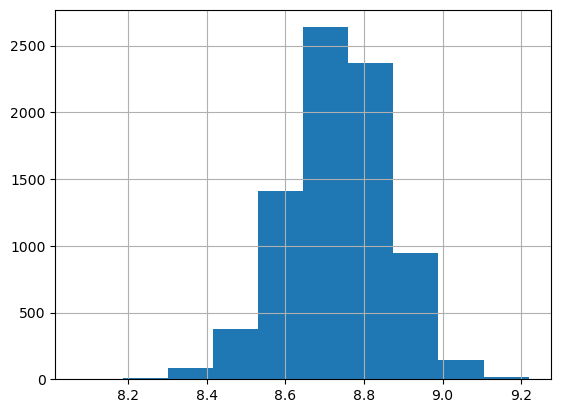

In [44]:
fit.draws_pd()["alpha"].hist()

4.

What is the estimate of the standard deviation of the noise? What is its interpretation? What is a credible interval for this quantity? Provide an accompanying histogram.

In [ ]:
# code goes here

5.

Use a scatterplot matrix and some credible intervals to visualize the $\beta$ weight samples. Do any of the predictors look unimportant? Do any of them look correlated?



In [ ]:
# code goes here

6.

Pick an arbitrary observation number (call it $i$). This corresponds to the index of a row in your predictor matrix. 

Plot the posterior predictions for $\tilde{y}_i$ for this particular predictor. There are many simulations for this one quantity.

Compare them to the actual dependent observation at that row $y_i$. Ideally your $y_i$ should be in the center of the histogram of predictions. Overlay a vertical line to show where this $y_i$ is.

Once you're convinced you have working code, copy/paste it into a function definition so that you can quickly switch between different predictions. 

NB: `stan` indexes start at $1$, while Python indexes start at $0$!

In [ ]:
def plot_posterior_predictive_one_predictor(arb_row):
    ...
    # copy/paste code in here
    ...
#plot_posterior_predictive_one_predictor(40)

## Problem 2: Running Variational Inference Algorithms

There's a lot of data here, which means we had to ignore it to quickly run MCMC, especially while we were prototyping. 

Use a variational inference algorithm on the full data set now. Do not recompile your stan model. You don't need to. This took a few minutes on my machine.


In [ ]:
# code goes here

1.

Plot a histogram for the alpha parameter. Does it look the same as the MCMC output? 

In [ ]:
# code goes here

2.

Plot the same scatterplot matrix for the betas? How does it look compared to the full MCMC output?

In [ ]:
# code goes here

## Problem 3: MAP Estimates

It still might be a bit slow for you, even if you are just running a variational algorithm. If you would like to do as the frequentists do--just optimize a function instead of trying to find the function itself--you can just find the MAP estimate:

$$
\text{argmax}_\theta \pi(\theta \mid y)
$$

At least this way we get the benefit of the prior. This is the fastest out of the three approaches so far because there is no attempt to find the posterior's function--just its mode.

1.

Use your model's `.optimize()` function to display the point estimates for your parameters.

In [ ]:
# code goes here